In [1]:
# LatticeBoltzmannDemo.py:  a two-dimensional lattice-Boltzmann "wind tunnel" simulation
# Uses numpy to speed up all array handling.
# Uses matplotlib to plot and animate the curl of the macroscopic velocity field.

# Copyright 2013, Daniel V. Schroeder (Weber State University) 2013

# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated data and documentation (the "Software"), to deal in 
# the Software without restriction, including without limitation the rights to 
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies 
# of the Software, and to permit persons to whom the Software is furnished to do 
# so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all 
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
# PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR 
# ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR 
# OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR 
# OTHER DEALINGS IN THE SOFTWARE.

# Except as contained in this notice, the name of the author shall not be used in 
# advertising or otherwise to promote the sale, use or other dealings in this 
# Software without prior written authorization.

# Credits:
# The "wind tunnel" entry/exit conditions are inspired by Graham Pullan's code
# (http://www.many-core.group.cam.ac.uk/projects/LBdemo.shtml).  Additional inspiration from 
# Thomas Pohl's applet (http://thomas-pohl.info/work/lba.html).  Other portions of code are based 
# on Wagner (http://www.ndsu.edu/physics/people/faculty/wagner/lattice_boltzmann_codes/) and
# Gonsalves (http://www.physics.buffalo.edu/phy411-506-2004/index.html; code adapted from Succi,
# http://global.oup.com/academic/product/the-lattice-boltzmann-equation-9780199679249).

# For related materials see http://physics.weber.edu/schroeder/fluids

https://en.wikipedia.org/wiki/Lattice_Boltzmann_methods

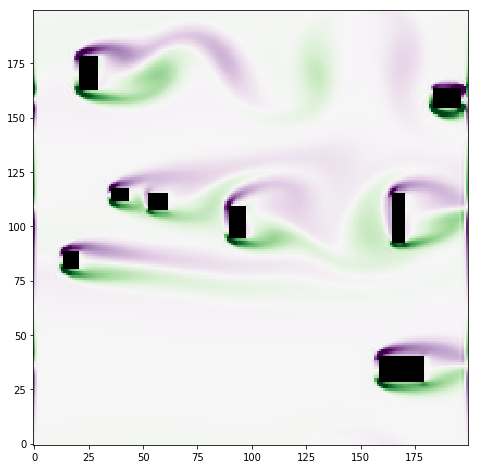

In [13]:
%matplotlib inline
import numpy as np
# , time, 
import matplotlib.pyplot
import matplotlib.animation
from IPython.display import HTML

# Define constants:
height = 200                            # lattice dimensions
width = 200
viscosity = 0.02                 # fluid viscosity
omega = 1 / (3 * viscosity + 0.5)        # "relaxation" parameter
initial_flow = 0.1                            # initial and in-flow speed
four9ths = 4.0/9.0                    # abbreviations for lattice-Boltzmann weight factors
one9th   = 1.0/9.0
one36th  = 1.0/36.0
# performanceData = False                # set to True if performance data is desired

# Initialize all the arrays to steady rightward flow:
n0 = four9ths * (np.ones((height, width)) - 1.5*initial_flow**2)    # particle densities along 9 directions
nN = one9th * (np.ones((height, width)) - 1.5*initial_flow**2)
nS = one9th * (np.ones((height, width)) - 1.5*initial_flow**2)
nE = one9th * (np.ones((height, width)) + 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
nW = one9th * (np.ones((height, width)) - 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
nNE = one36th * (np.ones((height, width)) + 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
nSE = one36th * (np.ones((height, width)) + 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
nNW = one36th * (np.ones((height, width)) - 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
nSW = one36th * (np.ones((height, width)) - 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
density = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW        # macroscopic density
horizontal_velocity = (nE + nNE + nSE - nW - nNW - nSW) / density                # macroscopic x velocity
vertical_velocity = (nN + nNE + nNW - nS - nSE - nSW) / density                # macroscopic y velocity

# Initialize barriers:
barrier = np.zeros((height, width), bool)                    # True wherever there's a barrier

for n in range(10):
    vbounds = height - 10
    hbounds = width - 10
    left = np.random.randint(1, hbounds)
    right = left + np.random.randint(5, 25)
    top = np.random.randint(1, vbounds)
    bottom = top - np.random.randint(5, 25)
    barrier[bottom:top, left:right] = True
    


# z = np.ones_like(np.arange(100).reshape(10, 10))
# for n in range(10):
#     left = np.random.randint(1, 10)
#     right = left + np.random.randint(0, 3)
#     top = np.random.randint(1, 10)
#     bottom = top - np.random.randint(0, 3)
#     z[bottom:top, left:right] = 0

# z

# barrier[int((height/2)-8):int((height/2)+8), int(height/4):int(height/2)] = True            # simple linear barrier
# barrier[60:80, 40:50] = True
# barrier[int((height/2)-8):int((height/2)+8), int(height/4)] = True            # simple linear barrier
barrierN = np.roll(barrier,  1, axis=0)                    # sites just north of barriers
barrierS = np.roll(barrier, -1, axis=0)                    # sites just south of barriers
barrierE = np.roll(barrier,  1, axis=1)                    # etc.
barrierW = np.roll(barrier, -1, axis=1)
barrierNE = np.roll(barrierN,  1, axis=1)
barrierNW = np.roll(barrierN, -1, axis=1)
barrierSE = np.roll(barrierS,  1, axis=1)
barrierSW = np.roll(barrierS, -1, axis=1)

# Move all particles by one step along their directions of motion (pbc):
def stream():
    global nN, nS, nE, nW, nNE, nNW, nSE, nSW
    nN  = np.roll(nN,   1, axis=0)    # axis 0 is north-south; + direction is north
    nNE = np.roll(nNE,  1, axis=0)
    nNW = np.roll(nNW,  1, axis=0)
    nS  = np.roll(nS,  -1, axis=0)
    nSE = np.roll(nSE, -1, axis=0)
    nSW = np.roll(nSW, -1, axis=0)
    nE  = np.roll(nE,   1, axis=1)    # axis 1 is east-west; + direction is east
    nNE = np.roll(nNE,  1, axis=1)
    nSE = np.roll(nSE,  1, axis=1)
    nW  = np.roll(nW,  -1, axis=1)
    nNW = np.roll(nNW, -1, axis=1)
    nSW = np.roll(nSW, -1, axis=1)
    # Use tricky boolean arrays to handle barrier collisions (bounce-back):
    nN[barrierN] = nS[barrier]
    nS[barrierS] = nN[barrier]
    nE[barrierE] = nW[barrier]
    nW[barrierW] = nE[barrier]
    nNE[barrierNE] = nSW[barrier]
    nNW[barrierNW] = nSE[barrier]
    nSE[barrierSE] = nNW[barrier]
    nSW[barrierSW] = nNE[barrier]
        
# Collide particles within each cell to redistribute velocities (could be optimized a little more):
def collide():
    global density, horizontal_velocity, vertical_velocity, n0, nN, nS, nE, nW, nNE, nNW, nSE, nSW
    density = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW
    horizontal_velocity = (nE + nNE + nSE - nW - nNW - nSW) / density
    vertical_velocity = (nN + nNE + nNW - nS - nSE - nSW) / density
    horizontal_velocity2 = horizontal_velocity * horizontal_velocity                # pre-compute terms used repeatedly...
    vertical_velocity2 = vertical_velocity * vertical_velocity
    u2 = horizontal_velocity2 + vertical_velocity2
    omu215 = 1 - 1.5*u2            # "one minus u2 times 1.5"
    horizontal_velocityvertical_velocity = horizontal_velocity * vertical_velocity
    n0 = (1-omega)*n0 + omega * four9ths * density * omu215
    nN = (1-omega)*nN + omega * one9th * density * (omu215 + 3*vertical_velocity + 4.5*vertical_velocity2)
    nS = (1-omega)*nS + omega * one9th * density * (omu215 - 3*vertical_velocity + 4.5*vertical_velocity2)
    nE = (1-omega)*nE + omega * one9th * density * (omu215 + 3*horizontal_velocity + 4.5*horizontal_velocity2)
    nW = (1-omega)*nW + omega * one9th * density * (omu215 - 3*horizontal_velocity + 4.5*horizontal_velocity2)
    nNE = (1-omega)*nNE + omega * one36th * density * (omu215 + 3*(horizontal_velocity+vertical_velocity) + 4.5*(u2+2*horizontal_velocityvertical_velocity))
    nNW = (1-omega)*nNW + omega * one36th * density * (omu215 + 3*(-horizontal_velocity+vertical_velocity) + 4.5*(u2-2*horizontal_velocityvertical_velocity))
    nSE = (1-omega)*nSE + omega * one36th * density * (omu215 + 3*(horizontal_velocity-vertical_velocity) + 4.5*(u2-2*horizontal_velocityvertical_velocity))
    nSW = (1-omega)*nSW + omega * one36th * density * (omu215 + 3*(-horizontal_velocity-vertical_velocity) + 4.5*(u2+2*horizontal_velocityvertical_velocity))
    # Force steady rightward flow at ends (no need to set 0, N, and S components):
    nE[:,0] = one9th * (1 + 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
    nW[:,0] = one9th * (1 - 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
    nNE[:,0] = one36th * (1 + 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
    nSE[:,0] = one36th * (1 + 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
    nNW[:,0] = one36th * (1 - 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)
    nSW[:,0] = one36th * (1 - 3*initial_flow + 4.5*initial_flow**2 - 1.5*initial_flow**2)

# Compute curl of the macroscopic velocity field:
def curl(horizontal_velocity, vertical_velocity):
    return np.roll(vertical_velocity,-1,axis=1) - np.roll(vertical_velocity,1,axis=1) - np.roll(horizontal_velocity,-1,axis=0) + np.roll(horizontal_velocity,1,axis=0)

# Here comes the graphics and animation...
theFig = matplotlib.pyplot.figure(figsize=(8,8))
fluidImage = matplotlib.pyplot.imshow(curl(horizontal_velocity, vertical_velocity), origin='lower', norm=matplotlib.pyplot.Normalize(-.1,.1), 
                                    cmap=matplotlib.pyplot.get_cmap('PRGn'), interpolation='none')
        # See http://www.loria.fr/~rougier/teaching/matplotlib/#colormaps for other cmap options
bImageArray = np.zeros((height, width, 4), np.uint8)    # an RGBA image
bImageArray[barrier,3] = 255                                # set alpha=255 only at barrier sites
barrierImage = matplotlib.pyplot.imshow(bImageArray, origin='lower', interpolation='none')

# Function called for each successive animation frame:
# startTime = time.clock()
#frameList = open('frameList.txt','w')        # file containing list of images (to make movie)
def nextFrame(arg):                            # (arg is the frame number, which we don't need)
#     global startTime
#     if performanceData and (arg%100 == 0) and (arg > 0):
#         endTime = time.clock()
# #         print "%1.1f" % (100/(endTime-startTime)), 'frames per second'
#         startTime = endTime
    #frameName = "frame%04d.png" % arg
    #matplotlib.pyplot.savefig(frameName)
    #frameList.write(frameName + '\n')
    for step in range(100):                    # adjust number of steps for smooth animation
        stream()
        collide()
    fluidImage.set_array(curl(horizontal_velocity, vertical_velocity))
    return (fluidImage, barrierImage)        # return the figure elements to redraw

animate = matplotlib.animation.FuncAnimation(theFig, nextFrame, interval=60, blit=True)
# matplotlib.pyplot.show()
HTML(animate.to_html5_video())

In [3]:
barrier

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

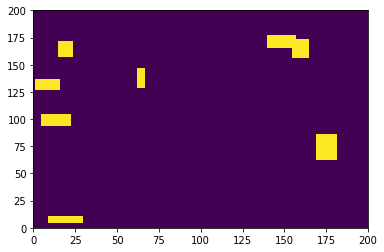

In [4]:
import matplotlib.pyplot as plt

plt.pcolormesh(barrier)

In [5]:
z = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
z[1:2,2:3]

array([[1]])

In [6]:
z[1:3,1:3] = 0
z[0:2, 0:2] = 2
z

array([[2, 2, 1],
       [2, 2, 0],
       [1, 0, 0]])

In [7]:
z = np.ones_like(np.arange(100).reshape(10, 10))

In [8]:
# z[3:5, 7:9] = 0
# z
z

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [9]:
z = np.ones_like(np.arange(100).reshape(10, 10))
for n in range(10):
    left = np.random.randint(1, 10)
    right = left + np.random.randint(0, 3)
    top = np.random.randint(1, 10)
    bottom = top - np.random.randint(0, 3)
    z[bottom:top, left:right] = 0

z

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [10]:
for n in range(10):
    center = (np.random.randint(0, 11), np.random.randint(0, 11))
    if center[0] and center[1] > 0:
        if center[0] and center[1] < 10:
            lower_left_corner = center[0] - np.random.randint(0, 2)
            upper_right_corner = center[1] + np.random.randin(0, 2)
            print('yasss')
    else:
        print('fuck you')
    

AttributeError: module 'numpy.random' has no attribute 'randin'